# Lesson 4: Tool Use and Conversational Chess

We will build a conversation chess game between two agent players . Who both can call a tool and make a legal moves on the chessboard 

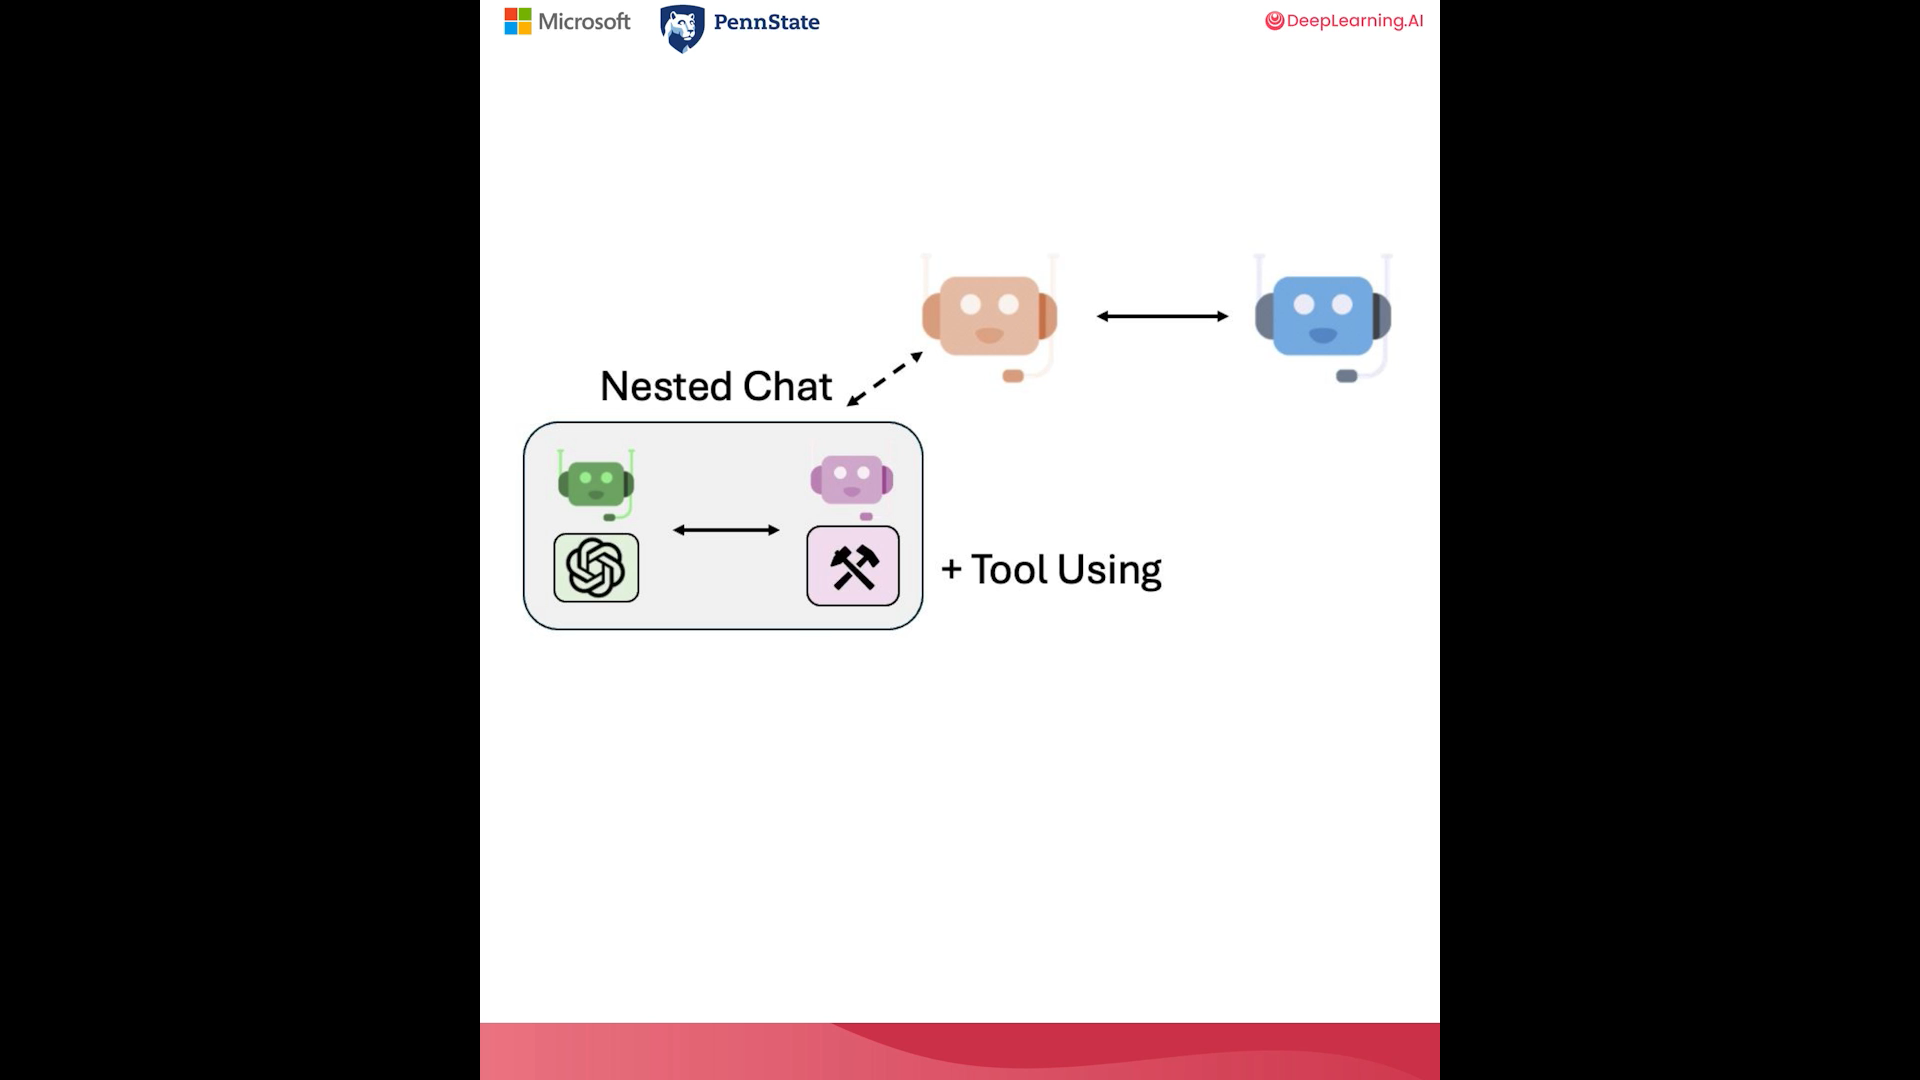

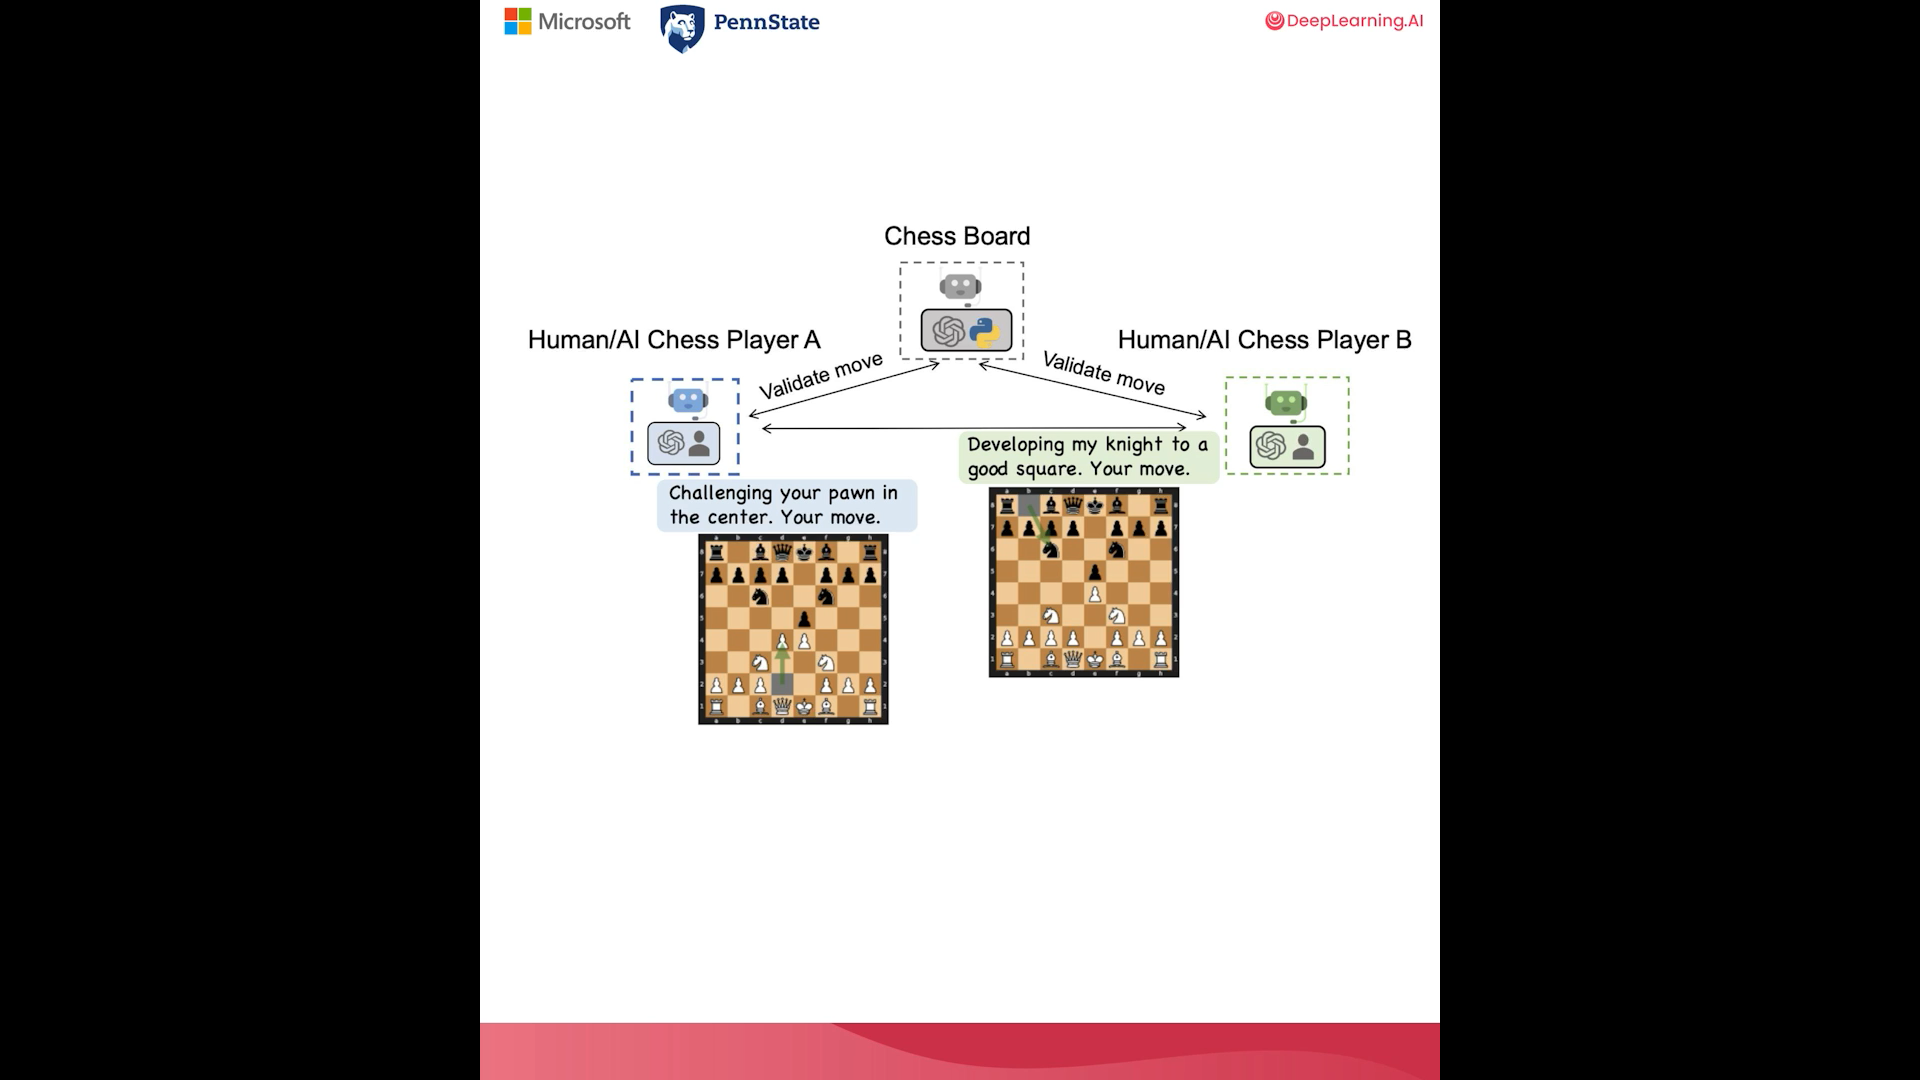

## Setup

In [1]:
llm_config = {"model": "gpt-4-turbo"}

In [2]:
import chess
import chess.svg
from typing_extensions import Annotated

## Initialize the chess board

In [3]:
board = chess.Board()

In [5]:
made_move = False ### This will keep track of whether move is made or not

## Define the needed tools

### 1. Tool for getting legal moves

In [6]:
def get_legal_moves(
    
    ### Annotated will allow agents to understand the format of returned content and the semantic meaning of it.
    
) -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

### 2. Tool for making a move on the board

In [8]:
def make_move(
    move: Annotated[str, "A move in UCI format."] ##i/p arg given by agent in uci format
) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    
    # Display the board.
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )
    
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from "\
    f"{chess.SQUARE_NAMES[move.from_square]} to "\
    f"{chess.SQUARE_NAMES[move.to_square]}."

## Create agents

You will create the player agents and a board proxy agents for the chess board.

In [9]:
from autogen import ConversableAgent

In [10]:
# Player white agent
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [11]:
# Player black agent
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [12]:
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


In [13]:
board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    is_termination_msg=check_made_move,
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

## Register the tools

A tool must be registered for the agent that calls the tool and the agent that executes the tool.

In [15]:
from autogen import register_function

In [16]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller, ## this will call the tool
        executor=board_proxy, ## This will execute the tool
        name="get_legal_moves",
        description="Get legal moves.",
    )
    
    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

In [17]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}}]

## Register the nested chats

Each player agent will have a nested chat with the board proxy agent to
make moves on the chess board to make sure that move is legal

In [18]:
player_white.register_nested_chats(
    trigger=player_black, ## When player white receives the message from player black. This nested chat will get triggered
    ## This nested chat will be performed before player white replies to player black
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

## Start the Game

The game will start with the first message.

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

**Note**: You might get a slightly different moves than what's shown in the video.

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_OsgcOtT2BMzfem5fgvj7IYnr): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_OsgcOtT2BMzfem5fgvj7IYn

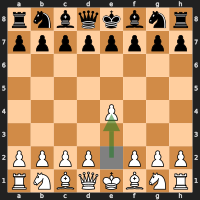

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_yJm5HHjEGSPBMa189d9uEE00) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from e2 to e4. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from e2 to e4. Your turn!

-------------------------------------

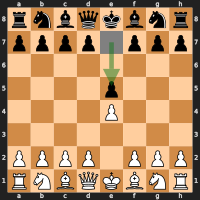

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_7t88mRA5A4Y3WE0kbd3xL49q) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from e7 to e5, mirroring your central pawn placement. Your move!

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from e7 to e5, mirroring your central pawn placement. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've 

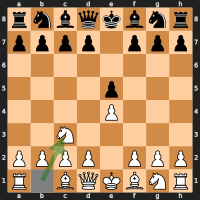

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_wwdTOT49aYJFmS75XyiDkv0Y) *****
Moved knight (♘) from b1 to c3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my knight from b1 to c3. This move strengthens my control of the central squares and prepares further development of my pieces. Your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my knight from b1 to c3. This move strengthens my control of the central squares and prepares further development of my pieces. Your turn!

--------------------------------------------------------------------------------


In [20]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

## Adding a fun chitchat to the game!

In [21]:
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [22]:
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [23]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True, ## You wont be able to seee intermediate conversations made by agents
        }
    ],
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


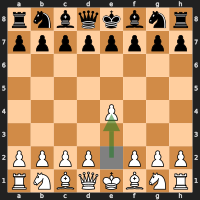


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

The pawn move from e2 to e4 is a classic opening strategy, aiming to control the center right away. It also opens paths for the queen and bishop.

Your move! Let's see how you respond.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


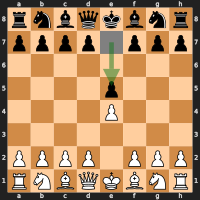


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

Great! The pawn from e7 has moved to e5. We've both opened a path for our pieces, setting us up for an engaging game.

Now, it's your turn! What's your strategy? Will you push forward or perhaps start developing your knights and bishops?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


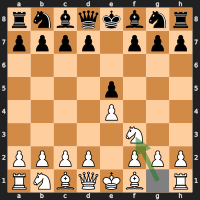


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I've moved the knight to f3, aiming to bolster our control over the center and prepare for further development. The game is shaping up nicely! What's your next plan?

--------------------------------------------------------------------------------


In [24]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

**Note:** 
To add human input to this game, add **human_input_mode="ALWAYS"** for both player agents.